In [1]:
from IPython.display import Image,HTML
import matplotlib.pyplot as plt
%matplotlib inline

FSSC Science Tools
=========================
Fermi LAT Analysis: Overview
-------------------------
*Jeremy S. Perkins, FSSC*
*Based on S. Fegan's Lecture which was based on...*

**Goal:** *Understand how Likelihood is Implemented in the LAT Science Tools*

# The LAT (gotta start somewhere...)
## or why do we have the analysis we have...
* The LAT is a pair conversion telescope made up of a tracker, a calorimeter, and an ACD

<img src="images/LATcutaway_full.jpg" alt="LAT" style="width:500px;">


Goals of Any Analysis
============================
* Test for presence of a source, measure its position in the sky
* Extract fluxes of sources of interest. Measure flux vs. time (“lightcurve”) to test for variability.
* Measure spectra of sources
    * Parameters of fitted spectral type, e.g. index of power-law, energy of exponential cut-off, or “super”-exponential cutoff (pulsars)
    * Flux as function of energy (“flux in bands”) 

What are we doing here...
==========================
* Maximum likelihood is framework/cookbook for estimation and hypothesis testing
* To use, must produce accurate model of data (the rest is derived by following the cookbook)
* Some portions of model are of interest to us
* Others are not
    * Background sources
    * Observational response
        * Must be mindful of systematic errors 

ScienceTools
=======================
* MLE and hypothesis testing is implemented for Fermi LAT data using ScienceTools.
* Data selection and binning into channels.
* Assists in producing of high-level sky model consisting of gamma-ray sources.
* Transformation into low-level Poisson model for each channel (observational response).
* Estimation of parameters through optimization (“minimization”) using log-likelihood.
* Calculation of upper limits.

Data Exploration
==========================
* FT1 files - list of events in FITS format
    * Browser: http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi
    * All-sky: http://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/
* Events reconstructed @SLAC and consist of:
    * Estimate of direction of origin
    * Estimate of the energy
    * “Probability” of being gamma ray (event classification)
    * Zenith angle, conversion point (front or back), detection time, ...

Data Set (4.8 years)
=============================

![cmap_nocuts](images/cmap_nocuts.png)

* Data set that we would like to analyze (using ML).
* Or in fact, it is a simplification.. the energy and time dependence is not shown! 

Data Set with Sensible Cuts
=============================
Appy Selection
* ∠Zn < 100deg
* Clean Events

<img src="images/cmap_z100.png" alt="fullskywithcut" style="width:500px;">



* Some part of the “background” can be removed: “cuts”. 
* Makes it easier to model (remaining) data.
* Rest cannot easily be separated: must be modeled. 

Region of Interest
=========================

![fullskyannote](images/cmap_z100_wCirc.png)

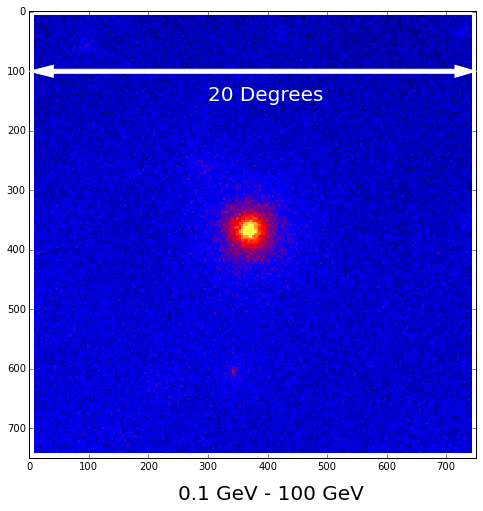

In [2]:
data = plt.imread('images/cmap_roi_example.png')
plt.figure(figsize=(8,8))
plt.imshow(data)

plt.annotate(
    '', xy=(0, 100), xycoords = 'data',
    xytext = (400, 100), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.annotate(
    '', xy=(750, 100), xycoords = 'data',
    xytext = (400, 100), textcoords = 'data',
    arrowprops = {'facecolor':'white','edgecolor':'white'})
plt.text(300, 150, '20 Degrees',fontsize=20,color='white')
plt.text(250,820,"0.1 GeV - 100 GeV",fontsize=20)
plt.savefig('images/cmap_roi_example_annote.png')
plt.show()

Region of Interest
=======================

![full energy cmap](images/cmap_roi_example_annote.png)


Region of Interest
=======================
* Don’t have to analyze full sky at once!
* Region of interest (ROI) around source.
* Larger: better measure background (>TS)
* Smaller: faster & lower background subtraction systematics (maybe!)
* About 20 degrees is good compromise.


Channels of postion and energy
====================================
0.1 GeV - 1 GeV
----------------------

<img src="images/cmap_roi_example_100.png" width='400'>


1 GeV - 10 GeV
----------------------

<img src="images/cmap_roi_example_1000.png" width='400'>

10 GeV - 100 GeV
----------------------

<img src="images/cmap_roi_example_10000.png" width='400'>

* Analyze events in channels of position and energy...
* ... as we are interested in spatial and energy dependence of sources
* ... best sensitivity achieved by using all information possible (as long as it can be modeled accurately!)

1. At higher energies there are fewer events,
2. but, sources look less spread out (PSF),
3. and there is less background.
4. Source seem most clearly detectable somewhere in the middle range.

Data Collection Profile
========================

![2orbit](images/2orbit.png)


<img src="images/map_z100_ss20noX.gif" alt="cmapanimation" style="width:600px;">



* Modeling must also account for the “observing profile”.
* Rate of γ rays from source depends on its (constantly changing) position in the field of view of the LAT. 

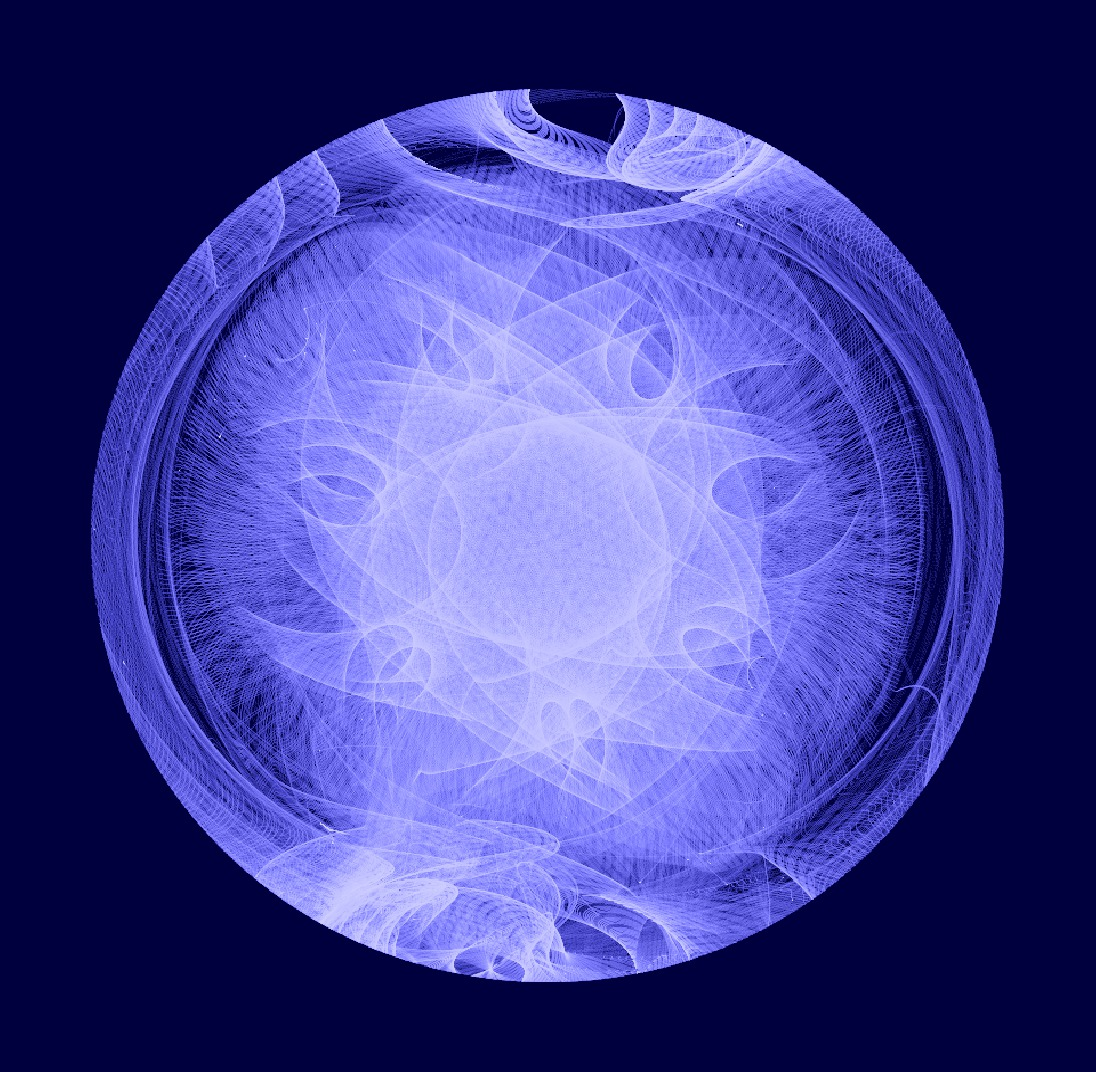

In [3]:
Image("http://apod.nasa.gov/apod/image/1205/LatPolar_Vela.jpg")

Model
====================
* Sky model
    * Spatial distribution of sources in ROI (point-like and extended sources)
    * Spectral model for each source
* Observational response (“exposure”)
    * Observational profile
    * Instrument response functions (IRFs)

Sky Model
===================
* Spatial and spectral model
* Point sources	(coordinates: RA & Dec)
* Extended sources	(map of emission)
* Diffuse sources	(full sky maps)
* Spectral types	(e.g. power law - index, flux)
* No time dependence!
* All these encoded in an XML input file
    * ST and LAT catalogs can help with this task 

Model for Our Sample ROI
=============================
* Sources from 3FGL catalog in (& on edge of) the ROI
    * Best-fit locations and spectral types (4yr)
* Diffuse isotropic
    * Extragalactic diffuse
    * Local cosmic rays
* Galactic diffuse
    * CR interactions
* Earth limb + sun 

![model locations](images/cmap_roi_example_1000_annote.png)

Model for our Sample ROI
===============================

* Point Sources: $$S(E,\hat{p},t) = \sum_i s_i(E,t)\delta(\hat{p}-\hat{p}_i)$$
* Galactic Diffuse: $$+ S_G(E,\hat{p})$$ 
* Extragalactic and Residual: $$+ S_{eg}(E,\hat{p})$$ 
* Other Extended Sources (Optional): $$+ \sum_l S_l(E,\hat{p},t)$$ 

Example for a power law spectral model
---------------------------------

$$S(E,\hat{p},t) = S(E,F_0,\Gamma,E_0) = F_0(\frac{E}{E_0})^{-\Gamma}$$


Observational Profile
===========================
* Pointing records from FT2 file - every 30 seconds
* RA & Dec of LAT pointing direction, the z-axis
    * (and of x-axis for phi dependence)
* Observation mode - sky survey, pointed
* Elizabeth described this yesterday 

Instrument Response Functions
================================
* Effective area - how the photon collecting area depends on energy and angle
* PSF - how the reconstructed photons are dispersed around their true direction in the sky
* Energy dispersion - how reconstructed photons are dispersed around their true energy
* IRF set must complement event selection used in analysis, eg. “P8R2_V6...” 

Effective Area (EA)
=============================

<img src="images/gAeffEnergy_P8R2_SOURCE_V6fb_10MeV.png" alt="EA" style="width:500px;">
<img src="images/gAeffTheta_10000_P8R2_SOURCE_V6fb_10MeV.png" alt="EAvsTheta" style="width:300px;">
<img src="images/gAeffPhi_P8R2_SOURCE_V6fb_10MeV.png" alt="EAvsPhi" style="width:300px;">

* Collecting area for events with TRUE energy E, and TRUE angles in spacecraft(θ,φ) 

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 


Point Spread Function
================================

<img src="images/gPsfAve95Energy_P8R2_SOURCE_V6fb_10MeV.png" alt="PSF" style="width:500px;">

* Point-spread function for events with TRUE energy E, and TRUE angles in spacecraft (θ,φ) 

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 

Energy Dispersion
================================

<img src="images/gEdispAve68Energy_P8R2_SOURCE_V6fb_sep_10MeV.png" alt="EDisp" style="width:500px;">

* Energy dispersion for events with TRUE energy E, and TRUE angles in spacecraft (θ,φ)

More info: http://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/index.html

or: http://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm 

Observational Response
===============================

<img src="images/2orbit.png" alt="PSF" style="width:200px;"><img src="images/gAeffEnergy_P8R2_SOURCE_V6fb_10MeV.png" alt="EA" style="width:200px;"><img src="images/gPsfAve95Energy_P8R2_SOURCE_V6fb_10MeV.png" alt="PSF" style="width:200px;"><img src="images/gEdispAve68Energy_P8R2_SOURCE_V6fb_sep_10MeV.png" alt="EDisp" style="width:200px;">

Observational Response
==============================

Instantaneous Response(Measured Params,True Params, Time) = EA x PSF x ED

$$R_t(E, \vec{p}, E^T, \vec{p^T},t) = A(E^T, \vec{p^T},t)
\times P(\vec{p},\vec{p^T},E^T,t) 
\times D(E; E^T,\vec{p},\vec{p^T},t)$$

Total Response

$$R(E, \vec{p}; E^T, \vec{p^T}) = \int dt R_t(E, \vec{p}; E^T,\vec{p^T},t)$$

Total 'Exposure' in units of cm<sup>2</sup>s

$$\int_0^\infty dE  \int _{4\pi} d\vec{p}\ R(E, \vec{p}, E^T, \vec{p^T})
= \int_{t_0}^{t_1} dt A(E^T, \vec{p^T},t) = X(E^T,\vec{p^T})$$

Depine average PSF and ED

$$R(E,\vec{p}, E^T, \vec{p^T}) = X(E^T,\vec{p^T}) \bar{P}(\vec{p},\vec{p^T},E^T) \bar{D}(E,E^T,\vec{p},\vec{p^T})$$

'Exposure' vs Time
=============================

![exposure](images/exposure.png)

* Instantaneous exposure for some source.
* Systematics may be present on short timescales or in some temporal analyses.
* See http://fermi.gsfc.nasa.gov/ssc/data/analysis/LAT_caveats_temporal.html


"Binned" or "Unbinned" (or Both)
===================================

"Binned" Likelihood Function
=================================
* Events binned into channels,_i_,of energy and position in sky:
$$(E_i, \vec{p}_i)$$
of size
$$\Delta E_i\Delta\vec{p}_i : n_i$$
* Log likelihood is (as in yesterday’s talk):
$$ln\mathcal{L}(\Theta) = \sum_{i\in Bins} n_i \ln \lambda_i(\Theta) - N_{pred}(\Theta)$$
* The Poisson mean for each channel is (ignoring ED in the second line):
$$\lambda_i(\Theta) = \Delta E_i\Delta\vec{p}_i \int dE^T \int_{ROI+} d\vec{p^T}
 S(E^T, \vec{p^T}|\Theta) R(E_i, \vec{p}_i, E^T, \vec{p^T})$$
$$= \Delta E_i\Delta\vec{p}_i \int_{ROI+} d\vec{p^T}
 S(E_i, \vec{p^T}|\Theta) R(E_i, \vec{p}_i, \vec{p^T})$$
* As expected:
$$N_{pred} = \sum_i \lambda_i(\Theta)$$


"Unbinned" Likelihood Function
===================================
* Infinitesimal channels in energy, position, time and conversion type, so 
$$n_i\in\{0,1\}$$
* The log likelihood is:
$$\ln\mathcal{L}(\Theta) = \sum_{i\in Events} \ln \lambda_i(\Theta) - N_{pred}(\Theta)$$
* Ignoring ED, the Poisson mean (density) for each channel (event) is:
$$\lambda_i(\Theta) = \int_{ROI+} d\vec{p^T}
 S(E_i, \vec{p^T}|\Theta) R_t(E_i, \vec{p}_i, \vec{p^T},t_i,type_i)$$
*And:
$$N_{pred}(\Theta) = \sum_{type} \int dE \int_{ROI} d\vec{p} \int dt \int_{ROI+} d\vec{p^T} \int dt
S(E,\vec{p^T}|\Theta) R_t(E, \vec{p}, \vec{p^T},t,type)$$

"Binned" or "Unbinned" (or both)
=================================
* Binned - _recommended by LAT collaboration_
    * Faster for long datasets (averaged IRFs)
    * Diffuse source calculation simpler
* Unbinned - _useful in certain circumstances_
    * Slow for long datasets (IRF for each event)
    * Diffuse source calculation very slow (but can be pre-calculated)
    * But higher TS values - model more accurate
* Mixed - “Composite Likelihood”
    * Can do an 'advanced topic' on this if needed



Analysis Flow - Binned
=========================
1. Create model
2. Extract data (`gtselect/gtmktime`)
3. Bin data into counts cube (`gtbin`)
4. Compute observation profile (`gtltcube`)
5. Compute exposure cube (`gtexpcube2`)
6. Produce source maps (`gtsrcmaps`)
7. Do MLE and compute TS (`gtlike`)

Analysis Flow - Unbinned
=============================
1. Create model
2. Extract data (`gtselect/gtmktime`)
3. Compute diffuse response (`gtdiffrsp`)
4. Compute observation profile (`gtltcube`)
5. Compute diffuse exp. maps (`gtexpmap`)
6. Do MLE and compute TS (`gtlike`)

What Does This Analysis Give Us?
=================================
* Estimates for all free parameters in the model (from maximizing likelihood)
* The covariance matrix (from 2nd derivative at MLEs) → Gaussian errors on parameters
* Flux and number of photons from each source
* TS for each source with a free parameter from which we get significance
* Residual counts histogram for ROI
* Convergence status 